In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1395263316329808250
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8593088794
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7182613315474814640
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [5]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "WiG20 data/"
stock_data_list = []

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [6]:
for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

In [7]:
def calculate_technical_indicators(data, rsi_period=10, so_period=14, so_d_period=4, tema_period=10, cgi_period=20, wpi_period=14):
    # rsi_period - number of sessions considered when calculating RSI
    # so_period - number of sessions considered when calculating stochastic oscillator K
    # so_d_period - numbers of sessions considered when calculating moving average of the stochastic oscillator K
    # tema_period - number of sessions considered when calculating TEMA
    # cgi_period - number of sessions considered when calculating CGI
    # wpi_period - number of sessions considered when calculating Williams' Percent Range

    # Moving averages for periods of 10, 30 and 60 days
    data['MovingAverage4'] = data['Close'].rolling(4).mean()
    data['MovingAverage7'] = data['Close'].rolling(7).mean()
    data['MovingAverage20'] = data['Close'].rolling(20).mean()

    # Relative Strength Index RSI
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = rsi_period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = rsi_period).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))

    # Rate of Change ROC
    data['ROC'] = data['Close'].pct_change()

    # Stochastic Oscillator K
    L14, H14 = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)

    # Moving average of the Stochastic Oscillator D
    data['D'] = data['K'].rolling(so_d_period).mean()

    # Moving Average Convergence / Divergence MACD
    EMA_26 = data['Close'].ewm(26, adjust=False).mean()
    EMA_12 = data['Close'].ewm(12, adjust=False).mean()
    data['MACD'] = EMA_12 - EMA_26

    # MACD Signal Line
    data['MACD_Signal'] = data['MACD'].ewm(9, adjust=False).mean()

    # MACD histogram
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    # Percentage Price Oscillator PPO
    data['PPO'] =(EMA_12 - EMA_26)/EMA_26

    # Triple Exponential Moving Average TEMA
    SEMA = data['Close'].ewm(tema_period, adjust=False).mean()
    DEMA = SEMA.ewm(tema_period, adjust=False).mean()
    data['TEMA'] = DEMA.ewm(tema_period, adjust=False).mean()

    # Commodity Channel Index CGI
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(cgi_period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(cgi_period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)

    # Williams' Percent Range
    data['Percent_Range'] = (data['Highest'].rolling(wpi_period).max() - data['Close']) / (data['Highest'].rolling(wpi_period).max() - data['Lowest'].rolling(wpi_period).min())

    return data

In [8]:
def scale_data(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [9]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

**Lerning based on prices and volume only**

In [10]:
scaled_stocks_basic = []
X_scalers_basic = []
Y_scalers_basic = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns='Date'))
  
    scaled_stocks_basic.append(scaled_stock)
    X_scalers_basic.append(X_scaler)
    Y_scalers_basic.append(Y_scaler)

In [11]:
X_all_basic = []
Y_all_basic = []
scaled_X_list_basic = []
scaled_Y_list_basic = []

for stock in scaled_stocks_basic:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list_basic.append(np.array(X))
    scaled_Y_list_basic.append(np.array(Y))
    X_all_basic = X_all_basic + X
    Y_all_basic = Y_all_basic + Y

X_all_basic, Y_all_basic = np.array(X_all_basic), np.array(Y_all_basic)
print('Shape of input matrix: ' + str(X_all_basic.shape))
print('Shape of output matrix: ' + str(Y_all_basic.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [12]:
from sklearn.model_selection import train_test_split

X_train_basic, X_valid_basic, Y_train_basic, Y_valid_basic = train_test_split(X_all_basic, Y_all_basic, test_size=2667, shuffle=False)

print('Shape of training input matrix: ' + str(X_train_basic.shape))
print('Shape of training output matrix: ' + str(Y_train_basic.shape))
print('Shape of validation input matrix: ' + str(X_valid_basic.shape))
print('Shape of validation output matrix: ' + str(Y_valid_basic.shape))

Shape of training input matrix: (73661, 60, 5)
Shape of training output matrix: (73661, 5)
Shape of validation input matrix: (2667, 60, 5)
Shape of validation output matrix: (2667, 5)


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 24,925
Trainable params: 24,925
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2302/2302 [==============================] - 19s 5ms/step - loss: 0.0033 - val_loss: 3.7504e-04
Epoch 2/15
2302/2302 [==============================] - 10s 4ms/step - loss: 4.9025e-04 - val_loss: 3.2739e-04
Epoch 3/15
2302/2302 [==============================] - 10s 4ms/step - loss: 4.7531e-04 - val_loss: 2.9333e-04
Epoch 4/15
2302/2302 [==============================]

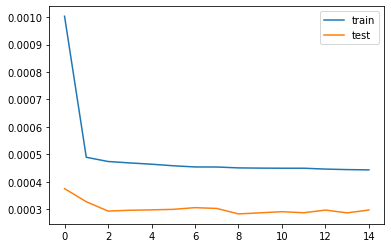

In [14]:
model = Sequential()
model.add(LSTM(64, input_shape=[X_train_basic.shape[1], X_train_basic.shape[2]]))#, return_sequences=True))
#model.add(LSTM(64))
model.add(Dense(100, activation='relu'))
model.add(Dense(Y_train_basic.shape[1]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train_basic, Y_train_basic, epochs=15, validation_data=(X_valid_basic, Y_valid_basic))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

predictions_basic = model.predict(X_valid_basic)
predictions_basic = Y_scalers_basic[0].inverse_transform(predictions_basic)
real_output_basic = Y_scalers_basic[0].inverse_transform(Y_valid_basic)

predicted_data_basic = pd.DataFrame(predictions_basic, columns=['Open_predicted', 'Close_predicted', 'Highest_predicted', 'Lowest_predicted', 'Volume_predicted'])
real_data_basic = pd.DataFrame(real_output_basic, columns=['Open_real', 'Close_real', 'Highest_real', 'Lowest_real', 'Volume_real'])
predictions_basic = pd.concat([real_data_basic, predicted_data_basic], axis=1)
print(predictions_basic[['Close_real', 'Close_predicted']].tail(20))

predictions_basic['Close_difference'] = abs(predictions_basic['Close_real'] - predictions_basic['Close_predicted'])
predictions_basic['Close_difference_percent'] = abs(predictions_basic['Close_real'] - predictions_basic['Close_predicted'])/predictions_basic['Close_real'] * 100

previous_Close_basic = predictions_basic['Close_real'].shift(-1)
Naive_forcast_MAPE = (abs(predictions_basic['Close_real'] - previous_Close_basic)/predictions_basic['Close_real'] * 100).mean()
predictions_MAPE_basic = predictions_basic['Close_difference_percent'].mean()

print('Naive forcast MAE: ' + str(round(abs(previous_Close_basic - predictions_basic['Close_real']).mean(),2)))
print('Predictions MAE: ' + str(round(predictions_basic['Close_difference'].mean(),2)))
print('Naive forcast MAPE: ' + str(round(Naive_forcast_MAPE,2)) + '%')
print('Predictions MAPE: ' + str(round(predictions_MAPE_basic,2)) + '%')

      Close_real  Close_predicted
2647   43.150455        43.317997
2648   43.190476        43.581524
2649   43.350559        42.900951
2650   44.711269        43.798607
2651   44.190997        44.442585
2652   42.990371        42.580387
2653   42.950351        42.790028
2654   42.590163        43.172344
2655   42.269996        42.069839
2656   42.390058        42.223164
2657   41.949829        42.196190
2658   41.589641        41.955204
2659   40.909286        41.164326
2660   39.628619        40.656403
2661   38.868222        39.296185
2662   37.987763        37.464127
2663   37.987763        37.641243
2664   37.947742        37.093342
2665   38.588076        38.343227
2666   38.387972        37.976379
Naive forcast MAE: 0.83
Predictions MAE: 0.65
Naive forcast MAPE: 1.96%
Predictions MAPE: 1.53%


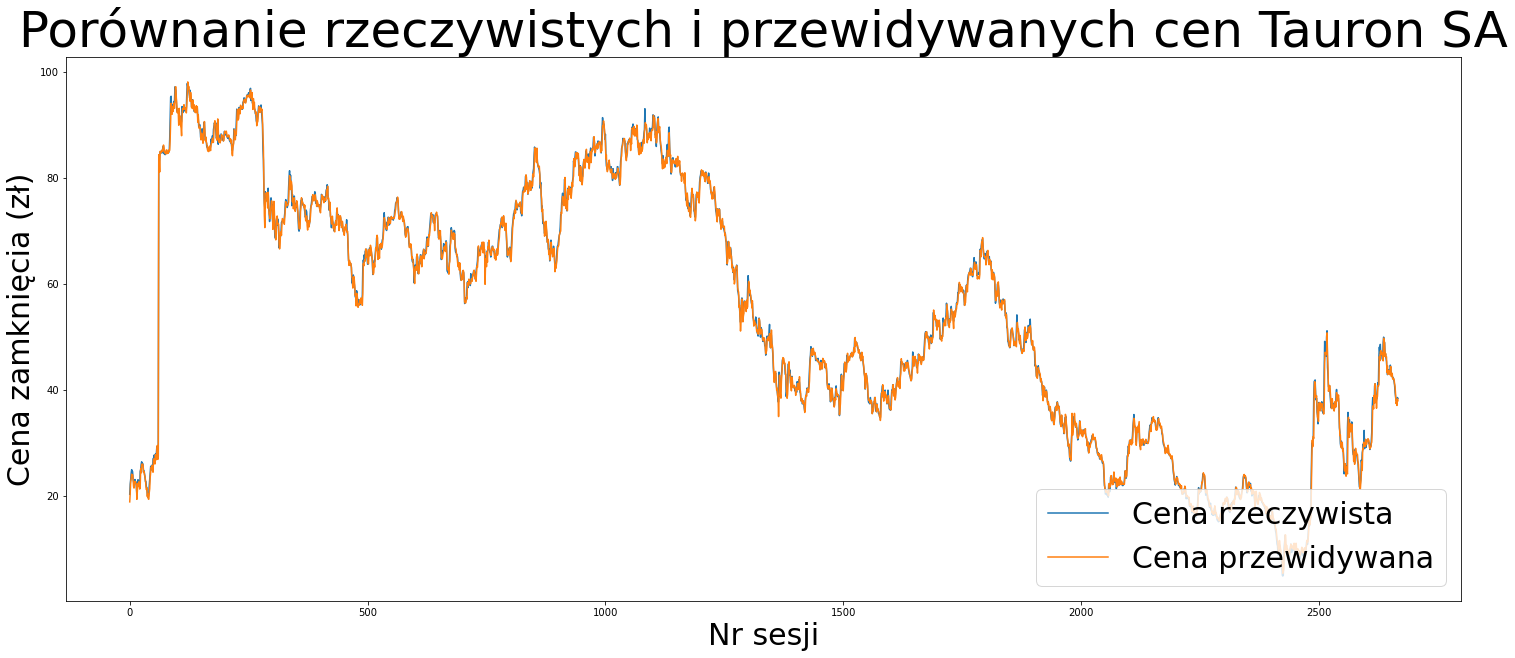

In [16]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions_basic['Close_real'])
plt.plot(predictions_basic['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

**Lerning based on prices, volume and technical indicators**

In [25]:
from IPython import display
# calculate_technical_indicators parameters -> data, rsi_period=10, so_period=14, so_d_period=4, tema_period=10, cgi_period=20, wpi_period=14
for i in range(len(stock_data_list)):
    stock_data_list[i] = calculate_technical_indicators(stock_data_list[i], rsi_period=60, so_period=5, so_d_period=3, tema_period=4, cgi_period=4, wpi_period=4)
    # moving averages return NaN when the considered period is greater than available data, these rows need to be dropped
    stock_data_list[i] = stock_data_list[i].dropna()

display.display(stock_data_list[0].head(100))

,Date,Open,Highest,Lowest,Close,Volume,MovingAverage4,MovingAverage7,MovingAverage20,RSI,ROC,K,D,MACD,MACD_Signal,MACD_Histogram,PPO,TEMA,CCI,Percent_Range
38,1998-07-28,17.722,17.722,17.177,17.346,195528,18.05225,18.207286,17.06905,59.475098,-0.015383,0.000000,2.354839e-01,0.810474,0.500601,0.309872,0.050158,16.873301,-13.502385,0.906111
39,1998-07-29,16.905,17.346,16.526,17.346,215878,17.71275,17.997429,17.19200,59.475098,0.000000,0.000000,0.000000e+00,0.795496,0.530091,0.265406,0.049097,17.007268,-9.419162,0.641765
40,1998-07-30,17.450,17.885,17.177,17.346,106166,17.41375,17.826571,17.30130,59.475098,0.000000,0.000000,0.000000e+00,0.779917,0.555073,0.224844,0.048010,17.118792,0.340123,0.569554
41,1998-07-31,17.885,17.885,17.450,17.617,114040,17.41375,17.788286,17.40495,61.113239,0.015623,1.000000,3.333333e-01,0.774656,0.577032,0.197624,0.047538,17.211211,4.182869,0.197204
42,1998-08-03,17.177,17.450,17.070,17.346,356092,17.41375,17.594286,17.46795,58.661576,-0.015383,0.000000,3.333333e-01,0.756963,0.595025,0.161938,0.046341,17.285316,-2.188172,0.396615
43,1998-08-04,17.450,18.269,17.450,18.269,127398,17.64450,17.555286,17.55510,63.778430,0.053211,1.000000,6.666667e-01,0.775895,0.613112,0.162783,0.047293,17.350206,14.091754,0.000000
44,1998-08-05,17.722,18.269,17.722,17.997,185865,17.80725,17.609571,17.63705,61.460552,-0.014889,0.705309,5.684363e-01,0.779663,0.629767,0.149896,0.047353,17.408804,7.100020,0.226856
45,1998-08-06,18.542,18.977,18.158,18.269,180868,17.97025,17.741429,17.77330,62.856216,0.015114,1.000000,9.017696e-01,0.791640,0.645954,0.145686,0.047886,17.464968,11.141720,0.371264
46,1998-08-07,18.815,19.635,18.542,19.635,229204,18.54250,18.068429,17.97785,68.735067,0.074771,1.000000,9.017696e-01,0.854516,0.666810,0.187705,0.051332,17.531405,11.025409,0.000000
47,1998-08-10,19.087,19.635,19.087,19.360,167366,18.81525,18.356143,18.11430,66.542928,-0.014006,0.832112,9.440374e-01,0.897002,0.689830,0.207172,0.053561,17.610821,7.052755,0.143753


In [26]:
scaled_stocks = []
X_scalers = []
Y_scalers = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns='Date'))
    scaled_stocks.append(scaled_stock)
    X_scalers.append(X_scaler)
    Y_scalers.append(Y_scaler)

In [27]:
X_all = []
Y_all = []
scaled_X_list = []
scaled_Y_list = []

for stock in scaled_stocks:
    X, Y = prepare_input_and_output(stock)
    scaled_X_list.append(np.array(X))
    scaled_Y_list.append(np.array(Y))
    X_all = X_all + X
    Y_all = Y_all + Y

X_all, Y_all = np.array(X_all), np.array(Y_all)
print('Shape of input matrix: ' + str(X_all.shape))
print('Shape of output matrix: ' + str(Y_all.shape))

Shape of input matrix: (75534, 60, 19)
Shape of output matrix: (75534, 5)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=2667, shuffle=False)

print('Shape of training input matrix: ' + str(X_train.shape))
print('Shape of training output matrix: ' + str(Y_train.shape))
print('Shape of validation input matrix: ' + str(X_valid.shape))
print('Shape of validation output matrix: ' + str(Y_valid.shape))

Shape of training input matrix: (72867, 60, 19)
Shape of training output matrix: (72867, 5)
Shape of validation input matrix: (2667, 60, 19)
Shape of validation output matrix: (2667, 5)


In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 28,509
Trainable params: 28,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2278/2278 [==============================] - 14s 5ms/step - loss: 0.0025 - val_loss: 4.2604e-04
Epoch 2/15
2278/2278 [==============================] - 10s 4ms/step - loss: 6.3841e-04 - val_loss: 3.0969e-04
Epoch 3/15
2278/2278 [==============================] - 10s 4ms/step - loss: 6.2967e-04 - val_loss: 5.8153e-04
Epoch 4/15
2278/2278 [=============================

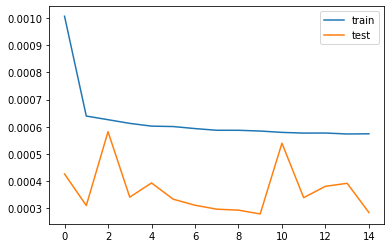

In [30]:
model = Sequential()
model.add(LSTM(64,input_shape=[X_train.shape[1], X_train.shape[2]]))#, return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(Dense(Y_train.shape[1]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_valid, Y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [31]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

predictions = model.predict(X_valid)
predictions = Y_scalers[0].inverse_transform(predictions)
real_output = Y_scalers[0].inverse_transform(Y_valid)

predicted_data = pd.DataFrame(predictions, columns=['Open_predicted', 'Close_predicted', 'Highest_predicted', 'Lowest_predicted', 'Volume_predicted'])
real_data = pd.DataFrame(real_output, columns=['Open_real', 'Close_real', 'Highest_real', 'Lowest_real', 'Volume_real'])
predictions = pd.concat([real_data, predicted_data], axis=1)
print(predictions[['Close_real', 'Close_predicted']].tail(20))

predictions['Close_difference'] = abs(predictions['Close_real'] - predictions['Close_predicted'])
predictions['Close_difference_percent'] = abs(predictions['Close_real'] - predictions['Close_predicted'])/predictions['Close_real'] * 100

previous_Close = predictions['Close_real'].shift(-1)
Naive_forcast_MAPE = (abs(predictions['Close_real'] - previous_Close)/predictions['Close_real'] * 100).mean()
predictions_MAPE = predictions['Close_difference_percent'].mean()

print('Naive forcast MAE: ' + str(round(abs(previous_Close - predictions['Close_real']).mean(),2)))
print('Predictions MAE: ' + str(round(predictions['Close_difference'].mean(),2)))
print('Naive forcast MAPE: ' + str(round(Naive_forcast_MAPE,2)) + '%')
print('Predictions MAPE: ' + str(round(predictions_MAPE,2)) + '%')

      Close_real  Close_predicted
2647   43.150455        43.450699
2648   43.190476        43.610271
2649   43.350559        43.135250
2650   44.711269        44.039394
2651   44.190997        44.643940
2652   42.990371        42.946789
2653   42.950351        42.978127
2654   42.590163        43.292374
2655   42.269996        42.294514
2656   42.390058        42.486805
2657   41.949829        42.278019
2658   41.589641        42.173340
2659   40.909286        41.313210
2660   39.628619        40.921535
2661   38.868222        39.693233
2662   37.987763        37.778206
2663   37.987763        37.671680
2664   37.947742        37.184448
2665   38.588076        38.167179
2666   38.387972        38.448978
Naive forcast MAE: 0.84
Predictions MAE: 0.74
Naive forcast MAPE: 2.11%
Predictions MAPE: 1.88%


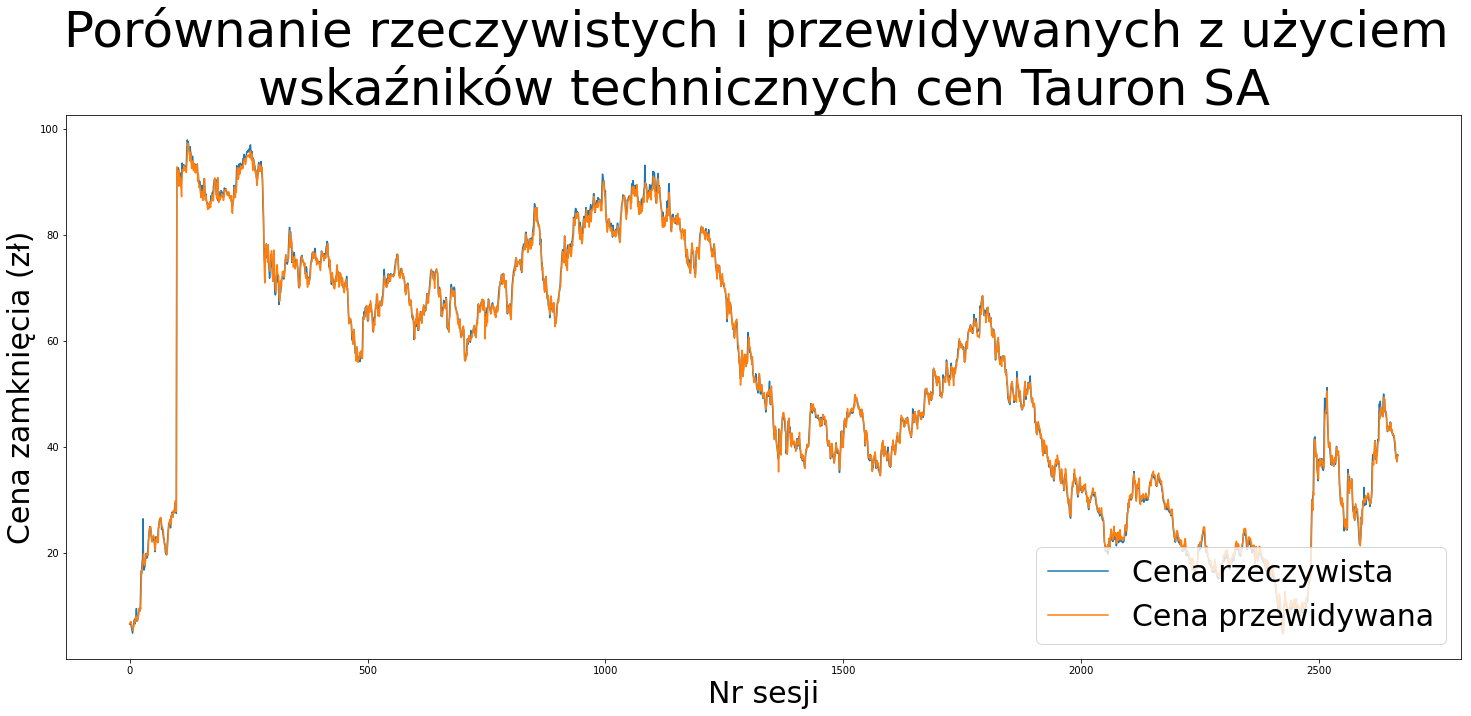

In [32]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych z użyciem \nwskaźników technicznych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions['Close_real'])
plt.plot(predictions['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()